<a href="https://colab.research.google.com/github/Renhas/ML-Airline/blob/main/Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек





In [ ]:
import warnings

warnings.simplefilter("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
%matplotlib inline
pd.options.display.max_rows = 10

# Подготовка данных

## Считывание данных

In [ ]:
train_data = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/Colab Notebooks/Airline/train.csv", sep=",")
test_data = pd.read_csv(filepath_or_buffer="/content/drive/MyDrive/Colab Notebooks/Airline/test.csv", sep=",")

## Удаление лишних столбцов и кодирование данных

In [ ]:
def data_prepare(data):
  data = data.drop(["Unnamed: 0", "id"], axis=1);
  data = data.dropna()
  data = data.drop_duplicates()
  data.Gender = data.Gender.map({"Male": 0, "Female": 1})
  data["Customer Type"] = data["Customer Type"].map({"Loyal Customer": 0, "disloyal Customer": 1})
  data["Type of Travel"] = data["Type of Travel"].map({"Business travel": 0, "Personal Travel": 1})
  data.Class = data.Class.map({"Business": 0, "Eco": 1, "Eco Plus": 2})
  data.satisfaction = data.satisfaction.map({"neutral or dissatisfied": 0, "satisfied": 1})
  return data


prepared_train = data_prepare(train_data)
prepared_test = data_prepare(test_data)

## Разбиение данных на метки значений и метки классов

In [ ]:
X_train = prepared_train.drop(columns="satisfaction", axis=1)
Y_train = prepared_train["satisfaction"]

X_test = prepared_test.drop(columns="satisfaction", axis=1)
Y_test = prepared_test["satisfaction"]

Стандартизация данных

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Нейронные сети

## Формирование данных о времени и точности

Не рекомендуется запускать из-за долгого времени работы

In [ ]:
layer_size = [i for i in range(100, 301, 100)]
activation = ["identity", "logistic", "tanh", "relu"]
solver = ['lbfgs', 'sgd|constant', 'sgd|invscaling', 'sgd|adaptive', 'adam']
iter = [i for i in range(200, 401, 100)]

results = {"layer_size": [], "activation": [],
           "solver": [], "iter": [],
           "learn_time": [], "clf_time": [], "presicion": []}

result = pd.read_csv("Result1.csv", sep=",").set_index(["layer_size", "activation", "solver", "iter"])
result = result.drop(["Unnamed: 0"], axis=1)

for parameter_set in itertools.product(layer_size, activation, solver, iter):
    print("\n" + ",".join([str(i) for i in parameter_set]))
    if parameter_set in result.index:
        print("Skip...")
        continue
    results["layer_size"].append(parameter_set[0])
    results["activation"].append(parameter_set[1])
    results["solver"].append(parameter_set[2])
    results["iter"].append(parameter_set[3])
    print("Classifier create...")

    solver = parameter_set[2]
    lr = 'constant'
    if "|" in parameter_set[2]:
        solver = parameter_set[2].split("|")[0]
        lr = parameter_set[2].split("|")[1]

    clf = MLPClassifier(hidden_layer_sizes=parameter_set[0] * X_train.shape[1],
                        activation=parameter_set[1], solver=solver,
                        learning_rate=lr, max_iter=parameter_set[3])
    print("Learn...")
    start = time.time()
    clf.fit(X_train, Y_train)
    end = time.time() - start
    results["learn_time"].append(end)

    print("Predict...")
    start = time.time()
    clf.predict(X_test)
    end = time.time() - start
    results["clf_time"].append(end)
    results["presicion"].append(clf.score(X_test, Y_test))

    print("Save...")
    dt = pd.DataFrame(results)
    dt = pd.concat([result.reset_index(), dt], sort=True).set_index(["layer_size", "activation", "solver", "iter"])
    dt.to_csv("/content/drive/MyDrive/Colab Notebooks/Airline/Result.csv")

## Исследование полученных значений

### Подготовка

Считывание данных

In [ ]:
result_table = pd.read_csv(filepath_or_buffer="Result.csv", sep=",")
result_table = result_table.sort_values(by=["layer_size", "activation", "solver", "iter"])
result_table = result_table.reset_index().drop(["index"], axis=1)
translate(result_table)["Время обучения"].sum()

231506.30791258812

Вспомогательные функции

In [ ]:
def translate(table: pd.DataFrame) -> pd.DataFrame:
  """Функция перевода строковых данных на русский язык.
  Изменения происходят в таблице, копий не создаётся.

  Args:
    table (pandas.DataFrame): исходная таблица

  Returns:
    pandas.DataFrame: изменённая исходная таблица
  """
  columns = {"layer_size": "Нейроны", "activation": "Функция активации",
             "solver": "Алгоритм подбора весов", "iter": "Итерации",
             "learn_time": "Время обучения", "clf_time": "Время классификации",
             "presicion": "Точность"}
  activation = {"identity": "Линейная", "logistic": "Сигмоида", "tanh": "Гипертангенс", "relu": "Усечённая"}
  solver = {'lbfgs': "Квазиньютон", 'sgd|constant': "Градиент, фиксированный",
            'sgd|invscaling': "Градиент, обратный",
            'sgd|adaptive': "Градиент, адаптивный", 'adam': "Адам"}
  table["activation"] = table["activation"].map(activation)
  table["solver"] = table["solver"].map(solver)
  table.rename(columns=columns, inplace=True)
  return table

In [ ]:
def plot_table(table: pd.DataFrame, yaxis: str, title: str, ylabel: str,
               legendpos:str ="best", yscale:str ="linear",
               legend_title:str="Функция активации, Алгоритм подбора весов",
               lines_style:dict=None) -> matplotlib.lines.Line2D:
  """Функция отрисовки таблицы

  Args:
    table (pandas.DataFrame): таблица
    yaxis (string): название столбца, значения которого будут составлять вертикальную ось
    title (string): название графика
    ylabel (string): подпись вертикальной оси
    legendpos (string): позиция легенды
    yscale (string): масштаб вертикальной оси
    legend_title (string): название легенды
    lines_style (dictionary): словарь, где ключом является название столбца,
    а значением - стиль линии, с помощью которой данный столбец будет отрисован
  
  Returns: 
    matplotlib.lines.Line2D: объект, возвращаемый функцией plot
  """
  if table.size == 0: return
  ax = table.plot(figsize=(10,7), kind="line", y=yaxis, title=title,
                  xlabel="(количество нейронов, итерации обучения)", ylabel=ylabel,
                  style=lines_style)
  ax.legend(fontsize="medium", title=legend_title,
            loc=legendpos, bbox_to_anchor=(1,1))
  ax.set_yscale(yscale)
  return ax               

Булевые маски для отбора нужных значений

In [ ]:
identity = result_table["Функция активации"] == "Линейная"
logistic = result_table["Функция активации"] == "Сигмоида"
tanh = result_table["Функция активации"] == "Гипертангенс"
relu = result_table["Функция активации"] == "Усечённая"

In [ ]:
lbfgs = result_table["Алгоритм подбора весов"] == "Квазиньютон"
sgd_constant = result_table["Алгоритм подбора весов"] == "Градиент, фиксированный"
sgd_invscaling = result_table["Алгоритм подбора весов"] == "Градиент, обратный"
sgd_adaptive = result_table["Алгоритм подбора весов"] == "Градиент, адаптивный"
adam = result_table["Алгоритм подбора весов"] == "Адам"

### Исследование времени обучения

Лучшее время

In [ ]:
best = result_table.sort_values(by="Время обучения").drop(["Время классификации", "Точность"], axis=1).head(5)
best.to_excel("best_time.xlsx", index=False)

Худшее время

In [ ]:
worst = result_table.sort_values(by="Время обучения", ascending=False).drop(["Время классификации", "Точность"], axis=1).head(5)
worst.to_excel("worst_time.xlsx", index=False)

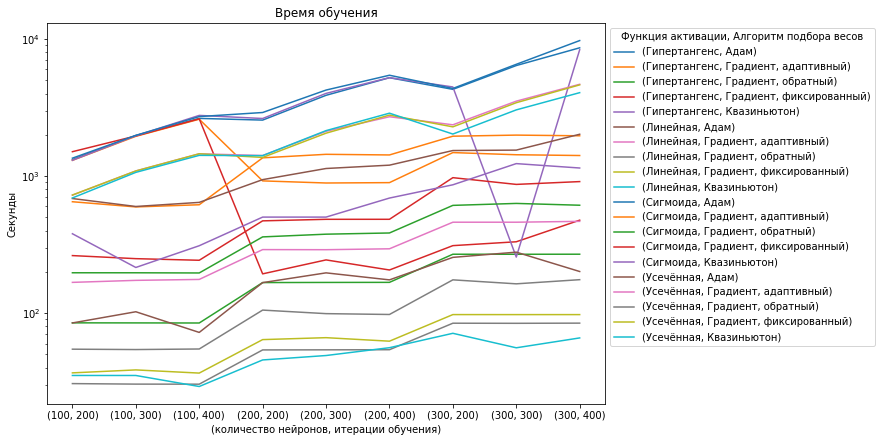

In [ ]:
pv_table = result_table.pivot_table(["Время обучения"], index=["Нейроны", "Итерации"],
                                    columns=["Функция активации", "Алгоритм подбора весов"])
plot_table(pv_table, "Время обучения", "Время обучения", "Секунды", yscale="log")

Разобьём общий график на более мелкие


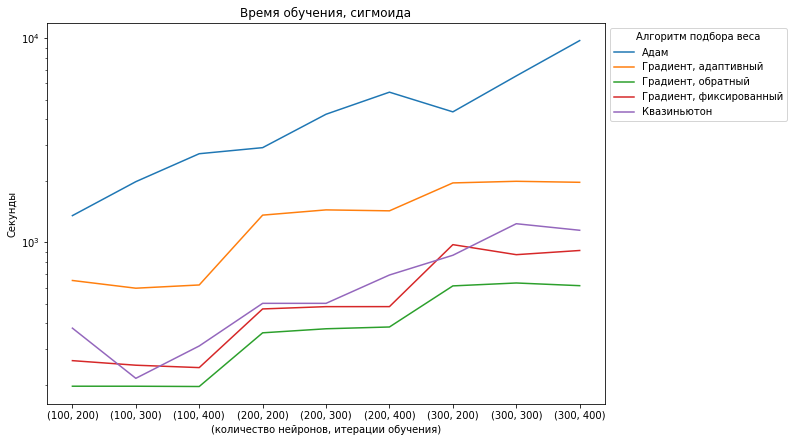

In [ ]:
pv_table = result_table[logistic]
pv_table = pv_table.pivot_table(["Время обучения"], index=["Нейроны", "Итерации"],
                                columns=["Алгоритм подбора весов"])
plot_table(pv_table, "Время обучения", "Время обучения, сигмоида",
           "Секунды", legend_title="Алгоритм подбора веса", yscale="log")

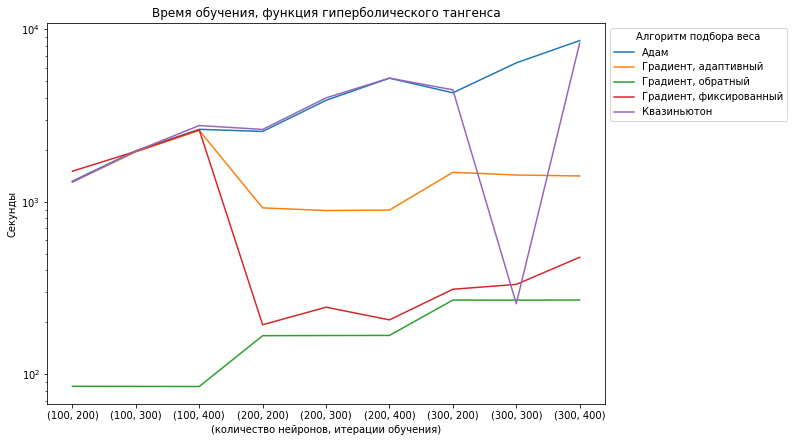

In [ ]:
pv_table = result_table[tanh]
pv_table = pv_table.pivot_table(["Время обучения"], index=["Нейроны", "Итерации"],
                                columns=["Алгоритм подбора весов"])
plot_table(pv_table, "Время обучения", "Время обучения, функция гиперболического тангенса",
           "Секунды", legend_title="Алгоритм подбора веса", yscale="log")

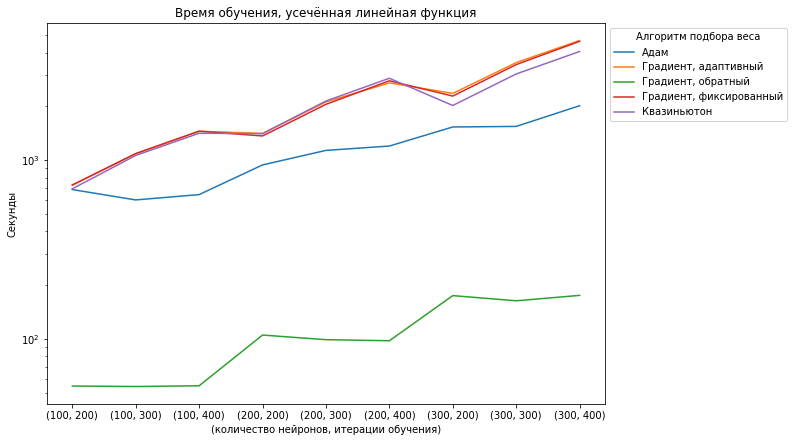

In [ ]:
pv_table = result_table[relu]
pv_table = pv_table.pivot_table(["Время обучения"], index=["Нейроны", "Итерации"],
                                columns=["Алгоритм подбора весов"])
plot_table(pv_table, "Время обучения", "Время обучения, усечённая линейная функция",
           "Секунды", legend_title="Алгоритм подбора веса", yscale="log")

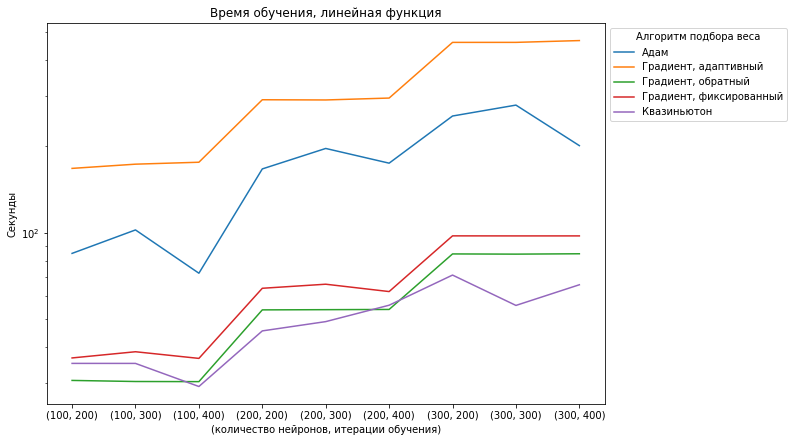

In [ ]:
pv_table = result_table[identity]
pv_table = pv_table.pivot_table(["Время обучения"], index=["Нейроны", "Итерации"],
                                columns=["Алгоритм подбора весов"])
plot_table(pv_table, "Время обучения", "Время обучения, линейная функция",
           "Секунды", legend_title="Алгоритм подбора веса", yscale="log")

### Исследование времени классификации

Лучшее время

In [ ]:
best = result_table.sort_values(by="Время классификации").drop(["Время обучения", "Точность"], axis=1).head(5)
best.to_excel("best_clf.xlsx", index=False)

Худшее время

In [ ]:
worst = result_table.sort_values(by="Время классификации",ascending=False).drop(["Время обучения", "Точность"], axis=1).head(5)
worst.to_excel("worst_clf.xlsx", index=False)

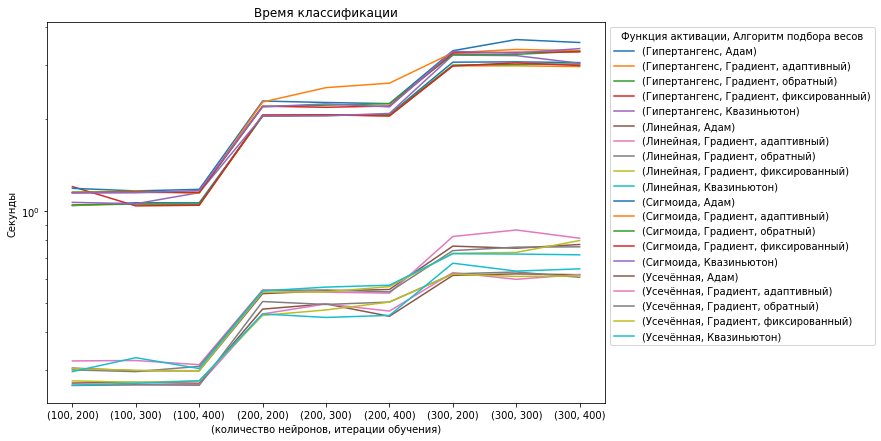

In [ ]:
pv_table = result_table.pivot_table(["Время классификации"], index=["Нейроны", "Итерации"],
                                    columns=["Функция активации", "Алгоритм подбора весов"])
plot_table(pv_table, "Время классификации", "Время классификации", "Секунды", yscale="log")

Также разобьём на более мелкие по времени

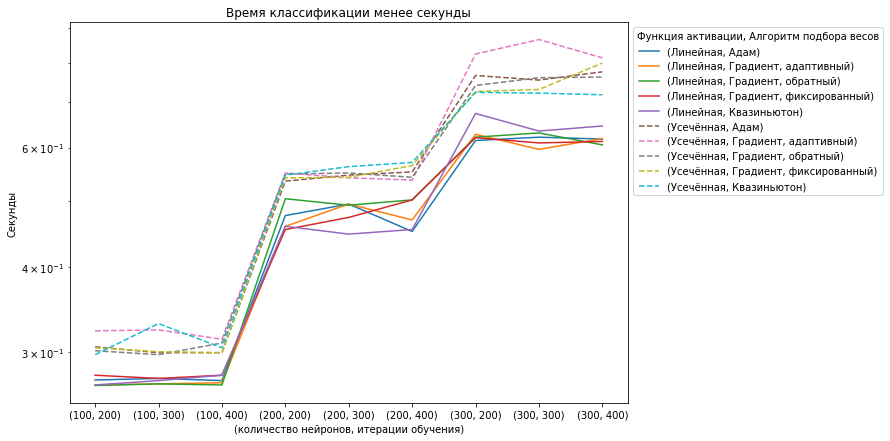

In [ ]:
pv_table_copy = pv_table[pv_table < 1].dropna(axis=1)
styles = {}
for columns in pv_table_copy .columns[:len(pv_table_copy)//2+1]:
  styles[columns[1:]] = "-"
for columns in pv_table_copy .columns[len(pv_table_copy)//2+1:]:
  styles[columns[1:]] = "--"

plot_table(pv_table_copy, "Время классификации", "Время классификации менее секунды", "Секунды", yscale="log",
           lines_style=styles)

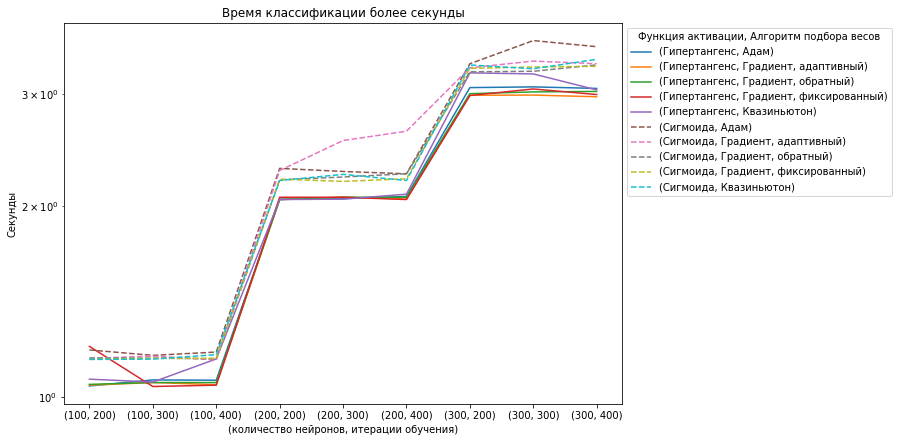

In [ ]:
pv_table_copy = pv_table[pv_table >= 1].dropna(axis=1)
styles = {}
for columns in pv_table_copy.columns[:len(pv_table_copy)//2+1]:
  styles[columns[1:]] = "-"
for columns in pv_table_copy.columns[len(pv_table_copy)//2+1:]:
  styles[columns[1:]] = "--"

plot_table(pv_table_copy, "Время классификации", "Время классификации более секунды", "Секунды", yscale="log",
           lines_style=styles)

### Исследование точности

Лучшая точность

In [ ]:
best = result_table.sort_values(by="Точность", ascending=False).drop(["Время обучения", "Время классификации"], axis=1).head(5)
best.to_excel("best_pr.xlsx", index=False)

Худшая точность

In [ ]:
worst = result_table[~(logistic & sgd_invscaling)].sort_values(by="Точность").drop(["Время обучения", "Время классификации"], axis=1).head(5)
worst.to_excel("worst_pr.xlsx", index=False)

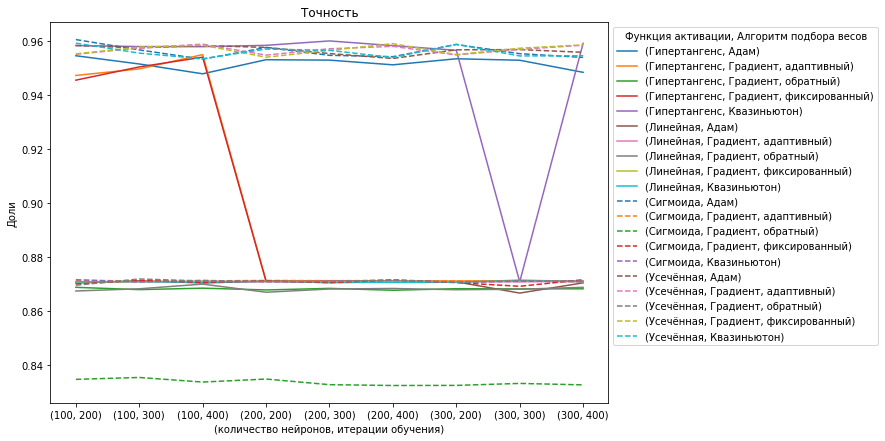

In [ ]:
pv_table = result_table.pivot_table(["Точность"], index=["Нейроны", "Итерации"],
                                    columns=["Функция активации", "Алгоритм подбора весов"])
styles = {}
for columns in pv_table.columns[:len(pv_table.columns)//2]:
  styles[columns[1:]] = "-"
for columns in pv_table.columns[len(pv_table.columns)//2:]:
  styles[columns[1:]] = "--"
plot_table(pv_table, "Точность", "Точность", "Доли",
           lines_style=styles)

Разобьём на участки точности

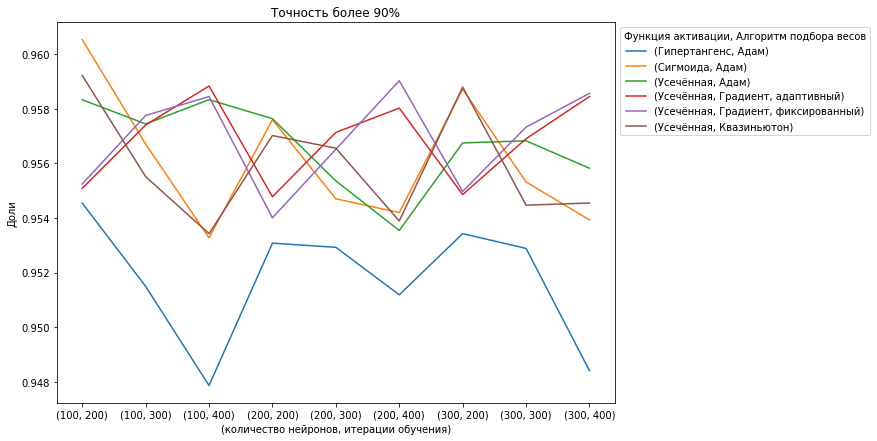

In [ ]:
plot_table(pv_table[pv_table > 0.94].dropna(axis=1), "Точность", "Точность более 94%", "Доли")

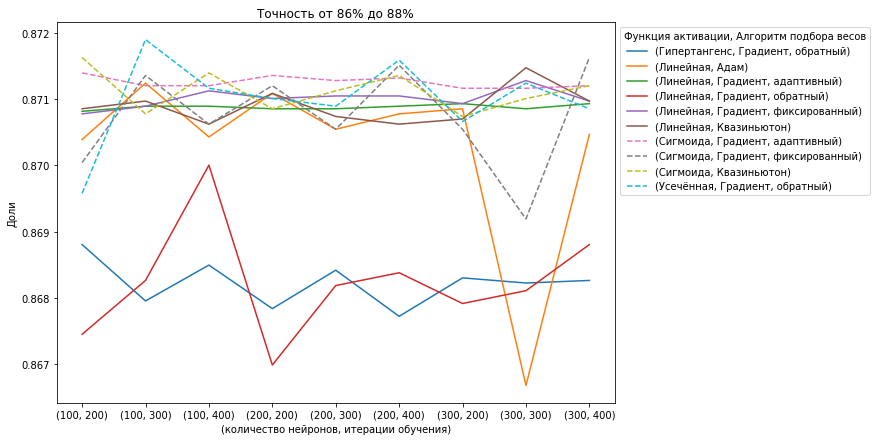

In [ ]:
plot_table(pv_table[(pv_table > 0.86) & (pv_table < 0.88)].dropna(axis=1), "Точность", "Точность от 86% до 88%", "Доли",
           lines_style=styles)